## Introduction to Data Science Assignment 0
__Parham Javan 810800008<br>__
__Yaser Azad 810800003__

# Environment Setup: Install & Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import random
import importlib
import math

# Check if Selenium is installed
if importlib.util.find_spec("selenium") is None:
    # Install Selenium
    !pip install selenium

# Check if BeautifulSoup (bs4) is installed
if importlib.util.find_spec("bs4") is None:
    # Install BeautifulSoup (bs4)
    !pip install beautifulsoup4

from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from scipy import stats

# Data Collection

In [3]:
# Step 1: Navigate to the main page URL

domain = "https://etherscan.io"
homepage_url = domain + "/txs"
driver = webdriver.Chrome()
driver.get(homepage_url)

print("SUCCESS: Navigation to etherscan URL!")

# Step 2: Locate the Transaction Data Table

wait = WebDriverWait(driver, 10)    # Wait for the table to load (dynamic content consideration)
wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'table')))

# Step 3: Extract the Data
# Extract the latest transaction's block number
transaction_table = driver.find_element(By.CLASS_NAME, 'table')
latest_transaction = transaction_table.find_element(By.XPATH, "//tbody/tr[1]")  #body table row 1
latest_block_number = latest_transaction.find_element(By.XPATH, "./td[4]/a").text    #table data

print("SUCCESS: Latest block number is acquired!\n")

# Set the number of latest blocks needed to be scraped
target_block_count = 10
transaction_data = []


# Step 4: Handle Pagination

for counter in range(target_block_count):
    # Navigate to the URL that a block's data is recorded
    block_number = int(latest_block_number) - counter
    query_string = "?block=" + str(block_number)
    current_block_url = homepage_url + query_string
    driver.get(current_block_url)
    
    print("SUCCESS: Navigation to block number " + str(counter + 1) + "'s URL!")

    while True:    # Continue scraping data until all block data is scraped from multiple pages
        wait = WebDriverWait(driver, 10)    # Wait for the table to load (dynamic content consideration)
        wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'table')))

        # Locate the transaction data table and its rows
        table = driver.find_element(By.CLASS_NAME, 'table')
        rows = table.find_elements(By.XPATH, "//tbody/tr")

        for row in rows:    # Extracting relevant columns using xpath of elements containing the actual data
            Txn_hash = row.find_element(By.XPATH, "./td[2]/div/span/a").text
            Method = row.find_element(By.XPATH, "./td[3]/span").text
            Block = row.find_element(By.XPATH, "./td[4]/a").text
            Age = row.find_element(By.XPATH, "./td[6]/span").text
            From = row.find_element(By.XPATH, "./td[8]/div/a").text
            To = row.find_element(By.XPATH, "./td[10]/div/a[1]").text
            Value = row.find_element(By.XPATH, "./td[11]/span").text
            Txn_Fee = row.find_element(By.XPATH, "./td[12]").text
            
            # Append the data to the database
            transaction_data.append({'Txn_Hash':Txn_hash, 'Method':Method, 'Block':Block, 'Age':Age, 'From':From, 'To':To, 'Value':Value, 'Txn_Fee': Txn_Fee})
    
        # Navigate to next page if there is one
        pagination_panel = driver.find_element(By.CLASS_NAME, 'pagination')
        if "disabled" not in pagination_panel.find_element(By.XPATH, ".//li[4]").get_attribute("class"):
            next_page_button = pagination_panel.find_element(By.XPATH, ".//li[4]/a")
            time.sleep(random.uniform(1, 3))    # Add a random delay between 1 and 3 seconds to consider rate limiting
            next_page_button.click()
        else:
            break   # All the block's data is scraped. Move on to the next block.
            
        time.sleep(random.uniform(1, 3))    # Add a random delay between 1 and 3 seconds to consider rate limiting
    
    print("SUCCESS: Data of block number " + str(counter + 1) + " is scraped!")
    
# Step 5: Store the Data

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(transaction_data)
# Save the raw DataFrame to a CSV file
df.to_csv('raw_ethereum_transactions.csv', index=False)

print("\nSUCCESS: Raw scraped data is saved!")

# Close the browser
driver.quit()

SUCCESS: Navigation to etherscan URL!


NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=123.0.6312.123)
Stacktrace:
	GetHandleVerifier [0x00007FF739187032+63090]
	(No symbol) [0x00007FF7390F2C82]
	(No symbol) [0x00007FF738F8EC65]
	(No symbol) [0x00007FF738F6CA7C]
	(No symbol) [0x00007FF738FFD687]
	(No symbol) [0x00007FF739012AC1]
	(No symbol) [0x00007FF738FF6D83]
	(No symbol) [0x00007FF738FC83A8]
	(No symbol) [0x00007FF738FC9441]
	GetHandleVerifier [0x00007FF7395825AD+4238317]
	GetHandleVerifier [0x00007FF7395BF70D+4488525]
	GetHandleVerifier [0x00007FF7395B79EF+4456495]
	GetHandleVerifier [0x00007FF739260576+953270]
	(No symbol) [0x00007FF7390FE54F]
	(No symbol) [0x00007FF7390F9224]
	(No symbol) [0x00007FF7390F935B]
	(No symbol) [0x00007FF7390E9B94]
	BaseThreadInitThunk [0x00007FFA859C54E0+16]
	RtlUserThreadStart [0x00007FFA8694485B+43]


# Data Cleaning

Step 1: Load the Data

In [11]:
# Load the CSV file into a DataFrame
df = pd.read_csv('raw_ethereum_transactions.csv')

# Function to convert wei (a unit of Ethereum cryptocurrency) to ether
def wei_to_eth(wei):
    return wei / 10**18

Step 2: Data Cleaning

In [12]:
# Remove duplicate rows from the DataFrame
df.drop_duplicates(inplace=True)

# Drop the useless columns from the DataFrame
df = df.drop(['Txn_Hash', 'Block', 'Age', 'From', 'To'], axis=1)

# Fill missing values with a specific value
df.fillna({'Value': 0, 'Txn_Fee': 0, 'Method': 'other'}, inplace=True)

# Create a new column 'Method_Category' with default value 'other'
df['Method_Category'] = 'Other'

# Define conditions for each category and update the 'Method_Category' accordingly
df.loc[df['Method'].str.lower().str.startswith('transfer'), 'Method_Category'] = 'Transfer'
df.loc[df['Method'].str.lower().str.startswith('0x'), 'Method_Category'] = 'Unidentified'
df.loc[df['Method'].str.lower().str.startswith('approve'), 'Method_Category'] = 'Approve'
df.loc[df['Method'].str.lower().str.startswith('execute'), 'Method_Category'] = 'Execute'
df.loc[df['Method'].str.lower().str.startswith('swap'), 'Method_Category'] = 'Swap'

# Drop the original 'Method' column since it's not needed anymore
df = df.drop('Method', axis=1)

# Rename the new 'Method_Category' column to 'Method'
df.rename(columns={'Method_Category': 'Method'}, inplace=True)

# Convert wei values to eth values
df['Value'] = df['Value'].apply(lambda x: wei_to_eth(int(x.split()[0])) if 'wei' in x else x)

# Convert Value & Txn_Fee columns to a numeric type
df['Value'] = df['Value'].str.replace('ETH' , '')   # Remove ETH from the value string
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
df['Txn_Fee'] = pd.to_numeric(df['Txn_Fee'], errors='coerce')

# Save the clean DataFrame to a CSV file
df.to_csv('clean_ethereum_transactions.csv', index=False)

print("SUCCESS: Clean data is saved!")

# Make a copy of the DataFrame and drop transactions with 'Value' == 0 and save to a CSV file
df_without_zeros = df.copy()
df_without_zeros = df_without_zeros.drop(df_without_zeros[df_without_zeros['Value'] == 0].index)
df_without_zeros.to_csv('clean_ethereum_transactions_without_zeros.csv', index=False)

zero_value_count = (df['Value'] == 0).sum()
print(f"\nNumber of transactions with 'Value' equal to zero: {zero_value_count}")

print(f"\nSUCCESS: {zero_value_count} values are deleted from clean data!")



SUCCESS: Clean data is saved!

Number of transactions with 'Value' equal to zero: 859

SUCCESS: 859 values are deleted from clean data!


# Data Analysis

## Statistical Analysis

Ungrouped Statistical Analysis

In [12]:
# Calculate statistical data for the 'Value' column (including 0 values)
Value_with0_stats = df[['Value']].agg(['mean', 'median', 'std', 'count']).transpose()

# Calculate statistical data for the 'Value' column (excluding 0 values)
Value_without0_stats = df_without_zeros[['Value']].agg(['mean', 'median', 'std', 'count']).transpose()

# Calculate statistical data for the 'Txn_Fee' column
Txn_Fee_stats = df[['Txn_Fee']].agg(['mean', 'median', 'std', 'count']).transpose()

# Merge all statistical data into one dataframe
merged_stats = pd.concat([Value_with0_stats, Value_without0_stats, Txn_Fee_stats], keys=['Full Dataset with 0:', 'Excluding 0 Values:', 'Full Dataset with 0:'])

# Rename the column headers
merged_stats.columns = ['Mean', 'Median', 'Standard Deviation', 'Count']

print("Ungrouped Statistical Analysis:\n")
print(merged_stats)

print("\nSUCCESS: Ungrouped Statistical Analysis conducted!")

Ungrouped Statistical Analysis:

                                  Mean    Median  Standard Deviation   Count
Full Dataset with 0: Value    0.494663  0.000000            9.438519  1705.0
Excluding 0 Values:  Value    0.996928  0.044530           13.384541   846.0
Full Dataset with 0: Txn_Fee  0.001401  0.000725            0.002080  1711.0

SUCCESS: Ungrouped Statistical Analysis conducted!


Grouped Statistical Analysis

In [15]:
# Group by 'Method' and calculate previous statistical calculations
Group_Value_with0_stats = df.groupby('Method')[['Value']].agg(['mean', 'median', 'std', 'count'])
Group_Value_without0_stats = df_without_zeros.groupby('Method')[['Value']].agg(['mean', 'median', 'std', 'count'])
Group_Txn_Fee_stats = df.groupby('Method')[['Txn_Fee']].agg(['mean', 'median', 'std', 'count'])

# Rename the column headers
Group_Value_with0_stats.columns = ['Mean', 'Median', 'Standard Deviation', 'Count']
Group_Value_without0_stats.columns = ['Mean', 'Median', 'Standard Deviation', 'Count']
Group_Txn_Fee_stats.columns = ['Mean', 'Median', 'Standard Deviation', 'Count']


print("Grouped Statistical Analysis:")
print("----------------------------------------------------------------------------------------")
print("--> Grouped analysis for Value (Full Dataset with 0):\n")
print(Group_Value_with0_stats)
print("----------------------------------------------------------------------------------------")
print("--> Grouped analysis for Value (Excluding 0 Values):\n")
print(Group_Value_without0_stats)
print("----------------------------------------------------------------------------------------")
print("--> Grouped analysis for Txn_Fee (Full Dataset with 0):\n")
print(Group_Txn_Fee_stats)

print("\nSUCCESS: Grouped Statistical Analysis conducted!")

# print("Ungrouped Statistical Analysis\n")

# print(merged_stats)

# print("\nSUCCESS: Ungrouped Statistical Analysis conducted!")

Grouped Statistical Analysis:
----------------------------------------------------------------------------------------
--> Grouped analysis for Value (Full Dataset with 0):

                  Mean    Median  Standard Deviation  Count
Method                                                     
Approve       0.000000  0.000000            0.000000    130
Execute       0.204838  0.000000            0.584601    171
Other         0.352816  0.000000            2.724189    283
Swap          0.185688  0.012227            0.343101     70
Transfer      0.711481  0.004500           12.441211    967
Unidentified  0.089594  0.000000            0.220750     84
----------------------------------------------------------------------------------------
--> Grouped analysis for Value (Excluding 0 Values):

                  Mean   Median  Standard Deviation  Count
Method                                                    
Execute       0.416992  0.15500            0.781316     84
Other         1.188654  0.

## Visualization

### Histogram Plots

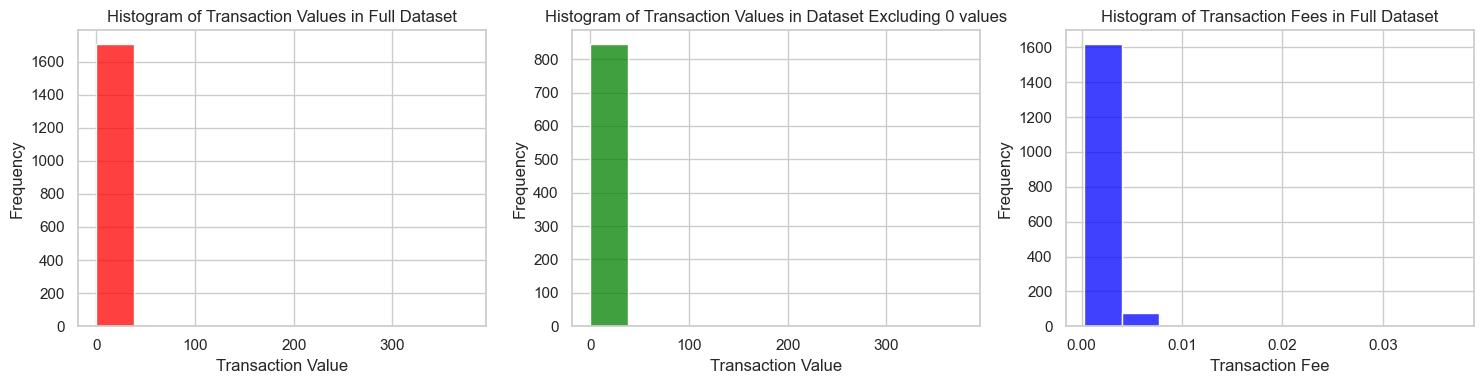

SUCCESS: Histogram Plots!


In [7]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# Plot the histogram for 'Value' in full dataset
sns.histplot(data=df, x='Value', bins=10, color='red', ax=axes[0])
axes[0].set_xlabel('Transaction Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Transaction Values in Full Dataset')

# Plot the histogram for 'Value' in dataset excluding 0 values
sns.histplot(data=df_without_zeros, x='Value', bins=10, color='green', ax=axes[1])
axes[1].set_xlabel('Transaction Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Transaction Values in Dataset Excluding 0 values')

# Plot the histogram for 'Txn_Fee' in full dataset
sns.histplot(data=df, x='Txn_Fee', bins=10, color='blue', ax=axes[2])
axes[2].set_xlabel('Transaction Fee')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Histogram of Transaction Fees in Full Dataset')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

print("SUCCESS: Histogram Plots!")

### Logarithmic Histogram Plots

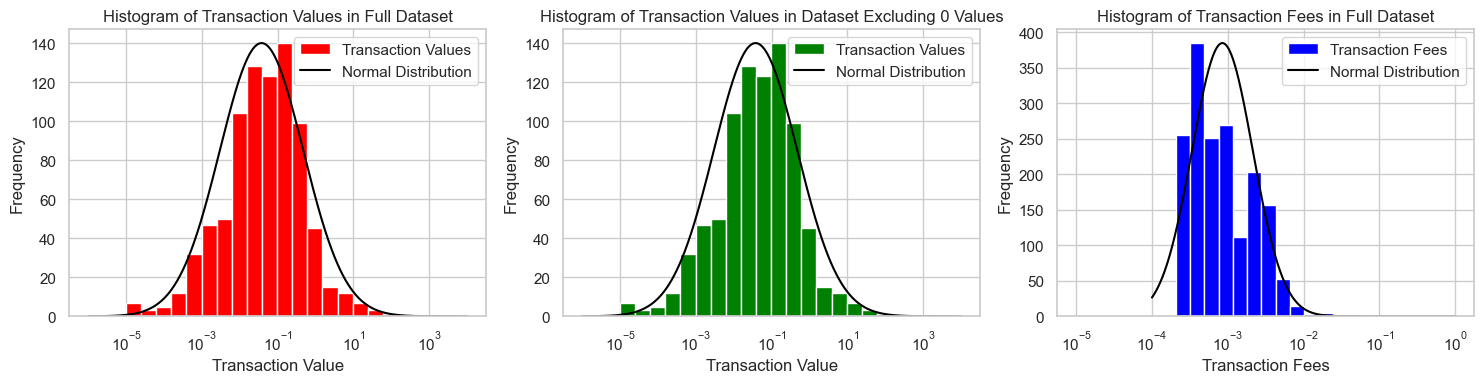

SUCCESS: Logarithmic Histogram Plots!


In [8]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# Plot the histogram for 'Value' in full dataset
hist, bins, _ = axes[0].hist(df['Value'], bins=np.logspace(np.log10(0.00001), np.log10(df['Value'].max()), 20), color='red', label="Transaction Values")

# Fit the normal distribution to the range 10^-6 to 10^4
min_val = 1e-6
max_val = 1e4
mu, sigma = stats.norm.fit(np.log10(df['Value'][(df['Value'] >= min_val) & (df['Value'] <= max_val)]))
x = np.linspace(np.log10(min_val), np.log10(max_val), 1000)
y = stats.norm.pdf(x, mu, sigma)

# Scale the normal distribution curve to match the maximum of the histogram
scaling_factor = max(hist) / max(y)
y *= scaling_factor

axes[0].plot(10**x, y, color='black', label='Normal Distribution')
axes[0].set_xscale('log')
axes[0].set_xlabel('Transaction Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Transaction Values in Full Dataset')
axes[0].legend()

# Plot the histogram for 'Value' in dataset excluding 0 values
hist, bins, _ = axes[1].hist(df_without_zeros['Value'], bins=np.logspace(np.log10(0.00001), np.log10(df_without_zeros['Value'].max()), 20), color='green', label="Transaction Values")

# Fit the normal distribution to the range 10^-6 to 10^4
min_val = 1e-6
max_val = 1e4
mu, sigma = stats.norm.fit(np.log10(df_without_zeros['Value'][(df_without_zeros['Value'] >= min_val) & (df_without_zeros['Value'] <= max_val)]))
x = np.linspace(np.log10(min_val), np.log10(max_val), 1000)
y = stats.norm.pdf(x, mu, sigma)

# Scale the normal distribution curve to match the maximum of the histogram
scaling_factor = max(hist) / max(y)
y *= scaling_factor

axes[1].plot(10**x, y, color='black', label='Normal Distribution')
axes[1].set_xscale('log')
axes[1].set_xlabel('Transaction Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Transaction Values in Dataset Excluding 0 Values')
axes[1].legend()

# Plot the histogram for 'Txn_Fee' in full dataset
hist, bins, _ = axes[2].hist(df['Txn_Fee'], bins=np.logspace(np.log10(0.00001), np.log10(df['Txn_Fee'].max()), 20), color='blue', label="Transaction Fees")

# Fit the normal distribution to the range 10^-4 to 10^0
min_val = 1e-4
max_val = 1e0
mu, sigma = stats.norm.fit(np.log10(df['Txn_Fee'][(df['Txn_Fee'] >= min_val) & (df['Txn_Fee'] <= max_val)]))
x = np.linspace(np.log10(min_val), np.log10(max_val), 1000)
y = stats.norm.pdf(x, mu, sigma)

# Scale the normal distribution curve to match the maximum of the histogram
scaling_factor = max(hist) / max(y)
y *= scaling_factor

axes[2].plot(10**x, y, color='black', label='Normal Distribution')
axes[2].set_xscale('log')
axes[2].set_xlabel('Transaction Fees')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Histogram of Transaction Fees in Full Dataset')
axes[2].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

print("SUCCESS: Logarithmic Histogram Plots!")

### Box Plots & Violin Plots

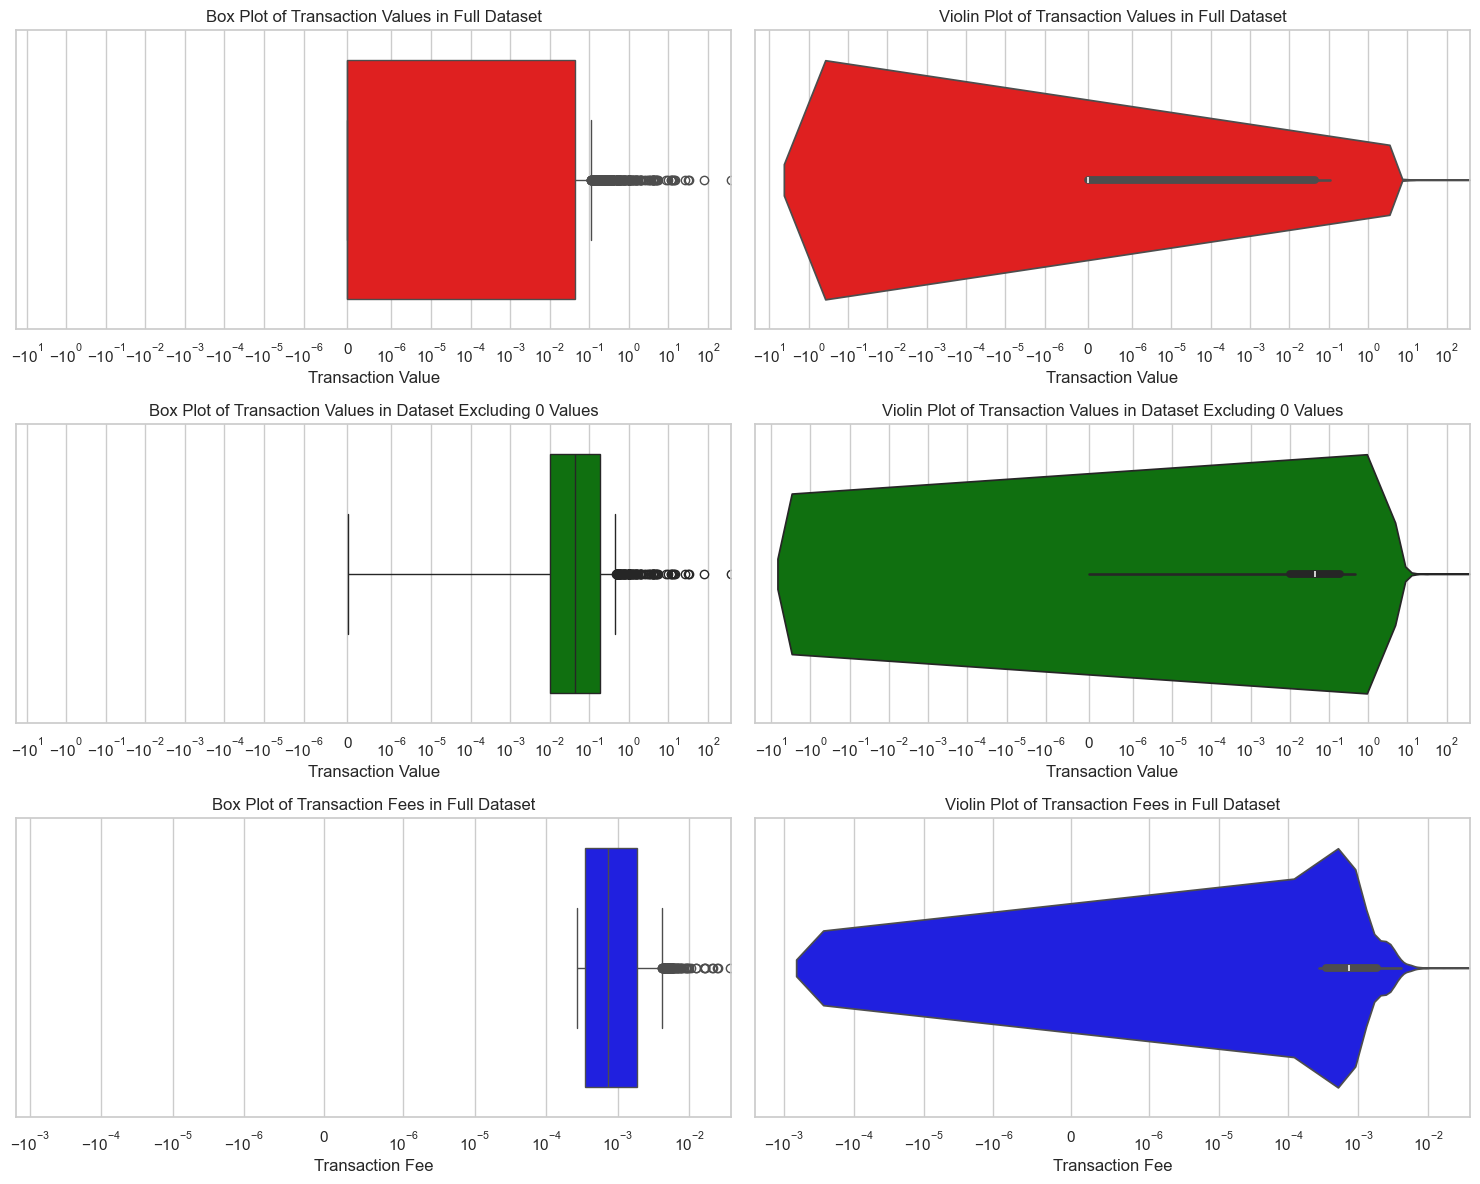

SUCCESS: Box Plots!
SUCCESS: Violin Plots!


In [9]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create subplots with 3 rows and 2 columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

# Box plot for 'Value' in full dataset
sns.boxplot(data=df, x='Value', ax=axes[0, 0], color='red', showfliers=True)
axes[0, 0].set_xscale('symlog', linthresh=1e-6)  # Set x-axis to symmetric log scale
axes[0, 0].set_xlabel('Transaction Value')
axes[0, 0].set_title('Box Plot of Transaction Values in Full Dataset')

# Violin plot for 'Value' in full dataset
sns.violinplot(data=df, x='Value', ax=axes[0, 1], color='red')
axes[0, 1].set_xscale('symlog', linthresh=1e-6)  # Set x-axis to symmetric log scale
axes[0, 1].set_xlabel('Transaction Value')
axes[0, 1].set_title('Violin Plot of Transaction Values in Full Dataset')

# Box plot for 'Value' in dataset excluding 0 values
sns.boxplot(data=df_without_zeros, x='Value', ax=axes[1, 0], color='green', showfliers=True)
axes[1, 0].set_xscale('symlog', linthresh=1e-6)  # Set x-axis to symmetric log scale
axes[1, 0].set_xlabel('Transaction Value')
axes[1, 0].set_title('Box Plot of Transaction Values in Dataset Excluding 0 Values')

# Violin plot for 'Value' in dataset excluding 0 values
sns.violinplot(data=df_without_zeros, x='Value', ax=axes[1, 1], color='green')
axes[1, 1].set_xscale('symlog', linthresh=1e-6)  # Set x-axis to symmetric log scale
axes[1, 1].set_xlabel('Transaction Value')
axes[1, 1].set_title('Violin Plot of Transaction Values in Dataset Excluding 0 Values')

# Box plot for 'Txn_Fee' in full dataset
sns.boxplot(data=df, x='Txn_Fee', ax=axes[2, 0], color='blue', showfliers=True)
axes[2, 0].set_xscale('symlog', linthresh=1e-6)  # Set x-axis to symmetric log scale
axes[2, 0].set_xlabel('Transaction Fee')
axes[2, 0].set_title('Box Plot of Transaction Fees in Full Dataset')

# Violin plot for 'Txn_Fee' in full dataset
sns.violinplot(data=df, x='Txn_Fee', ax=axes[2, 1], color='blue')
axes[2, 1].set_xscale('symlog', linthresh=1e-6)  # Set x-axis to symmetric log scale
axes[2, 1].set_xlabel('Transaction Fee')
axes[2, 1].set_title('Violin Plot of Transaction Fees in Full Dataset')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

print("SUCCESS: Box Plots!")
print("SUCCESS: Violin Plots!")

## Data Sampling

SRS

In [16]:
# Step 1: Load the Data
# Step 2: Data Cleaning

# Load the CSV file into a DataFrame
df = pd.read_csv('clean_ethereum_transactions_without_zeros.csv')

# Specify the sample size
sample_size = int(len(df) * 0.1)

# Step 3: Simple Random Sampling (SRS)

# Simple Random Sampling
srs_sample = df.sample(n=sample_size, random_state=42)  # Setting random_state for reproducibility

print("SUCCESS: Simple Random Sampling Complete!")

# Print the results
print("Simple Random Sample size:", len(srs_sample))

print("SRS:\n")

print(srs_sample)

SUCCESS: Simple Random Sampling Complete!
Simple Random Sample size: 85
SRS:

        Value   Txn_Fee    Method
66   0.008802  0.000357  Transfer
434  0.000474  0.000315  Transfer
198  0.031665  0.000357  Transfer
212  0.087126  0.000362  Transfer
651  0.014030  0.000327  Transfer
..        ...       ...       ...
806  0.164933  0.000324  Transfer
78        NaN  0.000725     Other
300  0.026000  0.000308  Transfer
656  0.001720  0.000328  Transfer
688  0.004500  0.000521  Transfer

[85 rows x 3 columns]


Stratified Sampling

In [17]:
# Step 1: Load the Data
# Step 2: Data Cleaning

# Load the CSV file into a DataFrame
df = pd.read_csv('clean_ethereum_transactions_without_zeros.csv')

# Step 3: Stratified Sampling

# Calculate the desired sample size for each method
desired_sample_sizes = (0.1 * df.groupby('Method').size()).astype(int)

# Split the DataFrame into strata based on 'Method'
strata = [stratum_df for _, stratum_df in df.groupby('Method')]

# Sample from each stratum using the dynamically calculated sample size
stratified_sample = pd.concat([stratum_df.sample(desired_sample_sizes[stratum_df['Method'].iloc[0]], random_state=42) for stratum_df in strata])

print("SUCCESS: Stratified Sampling Complete!")

# Print the results
print("Stratified Sample size:", len(stratified_sample))
print("Stratified Sample:\n")
print(stratified_sample)

SUCCESS: Stratified Sampling Complete!
Stratified Sample size: 83
Stratified Sample:

        Value   Txn_Fee        Method
788  0.062723  0.002144       Execute
2    0.200000  0.002373       Execute
523  0.011486  0.002717       Execute
238  5.000000  0.002184       Execute
132  1.000000  0.002368       Execute
..        ...       ...           ...
218  0.031400  0.000374      Transfer
527  0.001100  0.001005  Unidentified
344  1.200000  0.002032  Unidentified
234  0.500000  0.004385  Unidentified
529  0.134172  0.001006  Unidentified

[83 rows x 3 columns]


### Statistical Analysis

In [19]:
# Calculate statistical data for the 'Value' column of srs sample
Value_srs_stats = srs_sample[['Value']].agg(['mean', 'median', 'std', 'count']).transpose()

# Calculate statistical data for the 'Value' column of stratified sample
Value_stratified_stats = stratified_sample[['Value']].agg(['mean', 'median', 'std', 'count']).transpose()

# Calculate statistical data for the 'Value' column of the population
Value_population_stats = df_without_zeros[['Value']].agg(['mean', 'median', 'std', 'count']).transpose()

# Calculate statistical data for the 'Txn_Fee' column of srs sample
Txn_Fee_srs_stats = srs_sample[['Txn_Fee']].agg(['mean', 'median', 'std', 'count']).transpose()

# Calculate statistical data for the 'Txn_Fee' column of stratified sample
Txn_Fee_stratified_stats = stratified_sample[['Txn_Fee']].agg(['mean', 'median', 'std', 'count']).transpose()

# Calculate statistical data for the 'Txn_Fee' column of population
Txn_Fee_population_stats = df_without_zeros[['Txn_Fee']].agg(['mean', 'median', 'std', 'count']).transpose()

# Merge all statistical data into one dataframe
merged_stats = pd.concat([Value_srs_stats, Value_stratified_stats, Value_population_stats, Txn_Fee_srs_stats, Txn_Fee_stratified_stats, Txn_Fee_population_stats], keys=['Value | SRS sample:', 'Value | Stratified sample:', 'Value | Population', 'Fee | SRS sample:', 'Fee | Stratified sample:', 'Fee | Population'])

# Rename the column headers
merged_stats.columns = ['Mean', 'Median', 'Standard Deviation', 'Count']


print("Srs & Stratified samples Statistical Analysis:\n")

print(merged_stats)

print("\nSUCCESS: Srs & Stratified samples Statistical Analysis conducted!")

Srs & Stratified samples Statistical Analysis:

                                        Mean    Median  Standard Deviation  \
Value | SRS sample:        Value    0.412059  0.035500            1.709015   
Value | Stratified sample: Value    0.447195  0.063088            1.764449   
Value | Population         Value    0.996928  0.044530           13.384541   
Fee | SRS sample:          Txn_Fee  0.000739  0.000343            0.000966   
Fee | Stratified sample:   Txn_Fee  0.001084  0.000351            0.001542   
Fee | Population           Txn_Fee  0.001079  0.000351            0.001689   

                                    Count  
Value | SRS sample:        Value     84.0  
Value | Stratified sample: Value     82.0  
Value | Population         Value    846.0  
Fee | SRS sample:          Txn_Fee   85.0  
Fee | Stratified sample:   Txn_Fee   83.0  
Fee | Population           Txn_Fee  852.0  

SUCCESS: Srs & Stratified samples Statistical Analysis conducted!


### Visualization

### Histogram Plots

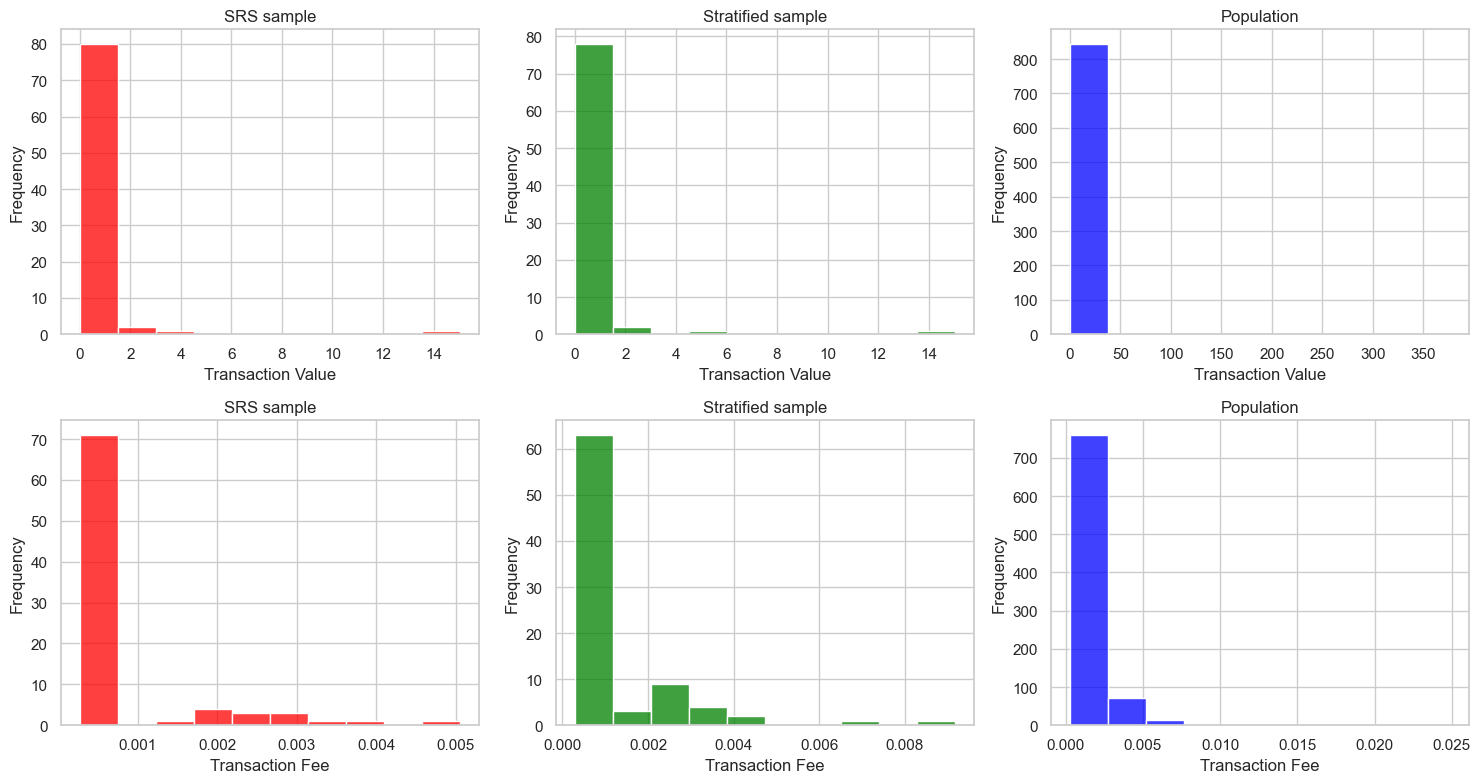

SUCCESS: Histogram Plots!


In [12]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Plot the histogram for 'Value' in SRS sample
sns.histplot(data=srs_sample, x='Value', bins=10, color='red', ax=axes[0][0])
axes[0][0].set_xlabel('Transaction Value')
axes[0][0].set_ylabel('Frequency')
axes[0][0].set_title('SRS sample')

# Plot the histogram for 'Value' in Stratified sample
sns.histplot(data=stratified_sample, x='Value', bins=10, color='green', ax=axes[0][1])
axes[0][1].set_xlabel('Transaction Value')
axes[0][1].set_ylabel('Frequency')
axes[0][1].set_title('Stratified sample')

# Plot the histogram for 'Value' in Population
sns.histplot(data=df_without_zeros, x='Value', bins=10, color='blue', ax=axes[0][2])
axes[0][2].set_xlabel('Transaction Value')
axes[0][2].set_ylabel('Frequency')
axes[0][2].set_title('Population')

# Plot the histogram for 'Txn_Fee' in SRS sample
sns.histplot(data=srs_sample, x='Txn_Fee', bins=10, color='red', ax=axes[1][0])
axes[1][0].set_xlabel('Transaction Fee')
axes[1][0].set_ylabel('Frequency')
axes[1][0].set_title('SRS sample')

# Plot the histogram for 'Txn_Fee' in Stratified sample
sns.histplot(data=stratified_sample, x='Txn_Fee', bins=10, color='green', ax=axes[1][1])
axes[1][1].set_xlabel('Transaction Fee')
axes[1][1].set_ylabel('Frequency')
axes[1][1].set_title('Stratified sample')

# Plot the histogram for 'Txn_Fee' in Population
sns.histplot(data=df_without_zeros, x='Txn_Fee', bins=10, color='blue', ax=axes[1][2])
axes[1][2].set_xlabel('Transaction Fee')
axes[1][2].set_ylabel('Frequency')
axes[1][2].set_title('Population')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

print("SUCCESS: Histogram Plots!")

### Logarithmic Histogram Plots

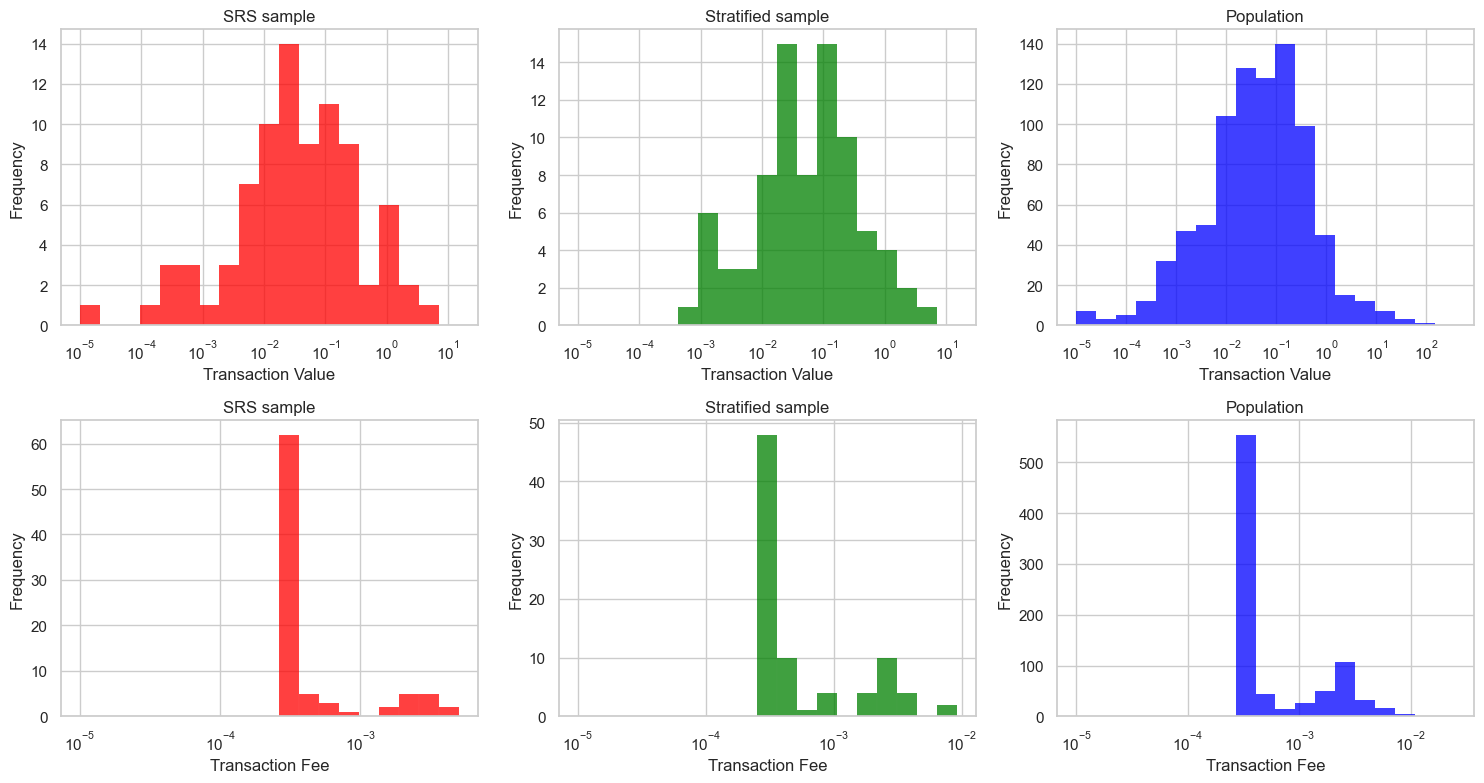

In [13]:
# Set the style for the plot
sns.set(style="whitegrid")

# Create subplots with 2 row and 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Plot the histogram for 'Value' in SRS sample
sns.histplot(data=srs_sample, x='Value', bins=np.logspace(np.log10(0.00001), np.log10(srs_sample['Value'].max()), 20), color='red', ax=axes[0][0])
axes[0][0].set_xscale('log')
axes[0][0].set_xlabel('Transaction Value')
axes[0][0].set_ylabel('Frequency')
axes[0][0].set_title('SRS sample')

# Plot the histogram for 'Value' in Stratified Sample
sns.histplot(data=stratified_sample, x='Value', bins=np.logspace(np.log10(0.00001), np.log10(stratified_sample['Value'].max()), 20), color='green', ax=axes[0][1])
axes[0][1].set_xscale('log')
axes[0][1].set_xlabel('Transaction Value')
axes[0][1].set_ylabel('Frequency')
axes[0][1].set_title('Stratified sample')

# Plot the histogram for 'Value' in Population
sns.histplot(data=df_without_zeros, x='Value', bins=np.logspace(np.log10(0.00001), np.log10(df_without_zeros['Value'].max()), 20), color='blue', ax=axes[0][2])
axes[0][2].set_xscale('log')
axes[0][2].set_xlabel('Transaction Value')
axes[0][2].set_ylabel('Frequency')
axes[0][2].set_title('Population')

# Plot the histogram for 'Txn_Fee' in SRS sample
sns.histplot(data=srs_sample, x='Txn_Fee', bins=np.logspace(np.log10(0.00001), np.log10(srs_sample['Txn_Fee'].max()), 20), color='red', ax=axes[1][0])
axes[1][0].set_xscale('log')
axes[1][0].set_xlabel('Transaction Fee')
axes[1][0].set_ylabel('Frequency')
axes[1][0].set_title('SRS sample')

# Plot the histogram for 'Txn_Fee' in Stratified sample
sns.histplot(data=stratified_sample, x='Txn_Fee', bins=np.logspace(np.log10(0.00001), np.log10(stratified_sample['Txn_Fee'].max()), 20), color='green', ax=axes[1][1])
axes[1][1].set_xscale('log')
axes[1][1].set_xlabel('Transaction Fee')
axes[1][1].set_ylabel('Frequency')
axes[1][1].set_title('Stratified sample')

# Plot the histogram for 'Txn_Fee' in Population
sns.histplot(data=df_without_zeros, x='Txn_Fee', bins=np.logspace(np.log10(0.00001), np.log10(df_without_zeros['Txn_Fee'].max()), 20), color='blue', ax=axes[1][2])
axes[1][2].set_xscale('log')
axes[1][2].set_xlabel('Transaction Fee')
axes[1][2].set_ylabel('Frequency')
axes[1][2].set_title('Population')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()